<h1> Email Subject line A/B Testing</h1>

<h3> KPI verified </h3>
&emsp; 1. Open Rate <br>
&emsp; 2. Click Rate <br>
&emsp; 3. Conversion Rate<br>
&emsp; 4. Revenue generation

<h3> Methods used for Test</h3>
&emsp; 1. Proportion Z test<br>
&emsp; 2. Independent T test<br> 
&emsp; 3. Monte carlo Simulation for visualizing distribution of KPIs

<h3> Data Preperation consideration</h3>
&emsp;1. Removing duplicate customers from Customer dataset :1138 duplicate value ( though have different hash email )<br>
&emsp;2. Preparing new variables for revenue and  customers conversion rate<br>
&emsp;3. Country wise dataframe for country segment analysis<br>
&emsp;4.Conversion rate is 1 if Order ID is not null.<br>
&emsp;5. if open rate is 0 then revenue = none even if order Id is present.

<b> Loading Required packages </b>
<br> -----------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import os
import warnings;warnings.filterwarnings('ignore');
os.chdir("D:\Python_Data\H&M_Case_Study") # Setting working Directory

<b> Importing DataSets </b>
<br> -----------------------------

<p> # Customer Datasets and removing duplicate customers in data (1138 rows) 

In [2]:
# Reading Data
customers = pd.read_csv("Customers.csv",sep=",")
                                                                                                                         
# 1138 Customers are duplicate thorugh their email is different ( it is adviced to delete duplicate )
# 50001 Unique customers
print('Number of duplicate customers :',len(customers['customer_no']) - len(np.unique(customers['customer_no']))) 

# Droping duplicate values 
# 582 values get dropped from Broup A and 556 valuesd get droped from Group B

customers.drop_duplicates(subset=['customer_no'], keep= False, inplace=True)

Number of duplicate customers : 1138


<p> # Email Engament Data and joining with customer dataset

In [3]:
# reading email dataset
email = pd.read_csv("Email Engagement.csv",sep=",")

# merging with customer dataset 
cust_email = email.merge(customers, on=['hash_email','country'], how='inner')

# Deleting hash email column
cust_email.drop(labels='hash_email', axis = 1, inplace = True)

<p># Reding transaction data and creating new variables

In [4]:
# Rerading transaction data
trans = pd.read_csv("Transactions_mini.csv",sep=",", parse_dates=['t_dat'])
# 9993 customer of transaction table is not present in customer dataset. Neither in A zgroup nor B group.

# Merging All data
trans['customer_no'] = trans.customer_no.astype('str')
all_df = cust_email.merge(trans, on=['customer_no','country'], how='left')

# Creating new variables for conversion and revenue analysis
all_df['conversion_rate'] = 0
all_df.loc[all_df.OrderID.notnull(),'conversion_rate'] = 1
all_df['revenue'] = trans['price'] - trans['discount']

# Deleting  non relevent rows
all_df.drop(labels=['OrderID','price','discount','quantity','return'], axis = 1, inplace = True)

all_df.loc[all_df['open_rate'] == 0,'revenue'] = None
all_df.loc[all_df['open_rate'] == 0,'conversion_rate'] = 0

# Sorting dataframe based on increasing transaction date
all_df.sort_values('t_dat',inplace = True)

# Creating dataframe for country wise segment analysis
Atlantis_df = all_df.loc[all_df.country == 'Atlantis',:]
Gilead_df   = all_df.loc[all_df.country == 'Gilead',:]
Oceania_df  = all_df.loc[all_df.country == 'Oceania',:]

all_df.sort_values('t_dat', inplace = True)
all_df.head()


,country,open_rate,click_rate,customer_no,Treatment_Group,t_dat,conversion_rate,revenue
45337,Gilead,0,0,36580340183,Group A,2015-01-01,0,NaN
53365,Gilead,0,0,58912060985,Group B,2015-01-01,0,NaN
5430,Atlantis,0,0,54854813240,Group A,2015-01-01,0,NaN
5431,Atlantis,0,0,54854813240,Group A,2015-01-01,0,NaN
31109,Gilead,1,0,35458928172,Group B,2015-01-01,1,14.99


<h3> Function for monte carlo simulation for distribution

In [37]:
# Function or proportional KPI open_rate, click_rate,conversion_rate distribution
def kpi_props(group1_df,group2_df,kpi):
    group1_proportion = []
    group2_proportion = []
    
    for i in range(10000):
        
        np.random.seed(i)
        group1_data = group1_df[kpi].to_list()
        group2_data = group2_df[kpi].to_list()
        
        sample1 = np.random.choice(group1_data,size = len(group1_data), replace = True)
        sample2 = np.random.choice(group2_data,size = len(group2_data), replace = True)
        
        p1 = sample1.sum()/len(group1_data)
        p2 = sample2.sum()/len(group2_data)
        
        group1_proportion.append(p1)
        group2_proportion.append(p2)

    return pd.DataFrame({'Group_A':group1_proportion,'Group_B':group2_proportion})

# Function or continuous KPI revenue distribution

def revenue_means(group1_df,group2_df,kpi = 'revenue'):
    group1_mean = []
    group2_mean = []
    
    for i in range(10000):
        
        np.random.seed(i)
        group1_data = group1_df.loc[group1_df[kpi].notnull(),kpi].to_list()
        group2_data = group2_df.loc[group2_df[kpi].notnull(),kpi].to_list()
        
        sample1 = np.random.choice(group1_data,size = len(group1_data), replace = True)
        sample2 = np.random.choice(group2_data,size = len(group2_data), replace = True)
        
        mean1 = sample1.mean()
        mean2 = sample2.mean()
        
        group1_mean.append(mean1)
        group2_mean.append(mean2)

    return pd.DataFrame({'Sample_A Mean':group1_mean,'Sample_B Mean':group2_mean})


<h3> Preparing for EDA

In [18]:
# Looking for averages and proportions in provided data

# all country together
all_data_avg = all_df.describe()
all_data_avg = all_data_avg[all_data_avg.index =='mean']
print(all_df.groupby('customer_no')['revenue'].sum().mean())

# Channel wise description
k = all_df.groupby(['country','customer_no']).sum()['revenue']
k.groupby('country').mean()

12.181176745920487


country
Atlantis    16.576432
Gilead      12.669453
Oceania      6.350239
Name: revenue, dtype: float64

In [38]:
# Separating data accourding to the treatment group
A_group_df = all_df.loc[ all_df['Treatment_Group'] == 'Group A',['t_dat','revenue','open_rate','click_rate','conversion_rate']]
B_group_df = all_df.loc[ all_df['Treatment_Group'] == 'Group B',['t_dat','revenue','open_rate','click_rate','conversion_rate']]

A_group_df.head()
##creating data for analysing distributions of KPI separately according to the treatment group
# open_dist = kpi_props(group1_df = A_group_df ,group2_df = B_group_df ,kpi = 'open_rate')
# click_dist = kpi_props(group1_df = A_group_df ,group2_df = B_group_df ,kpi = 'click_rate')
# conversion_dist = kpi_props(group1_df = A_group_df ,group2_df = B_group_df ,kpi = 'conversion_rate')
# revenue_dist = revenue_means(group1_df = A_group_df,group2_df = B_group_df,kpi = 'revenue')
revenue_dist.head(10)

,Sample_A Mean,Sample_B Mean
0,13.784657,13.726542
1,13.869936,13.655401
2,13.676488,13.762773
3,13.644800,13.741361
4,13.783738,13.666390
5,13.650723,13.737547
6,13.699290,13.664356
7,13.759553,13.655298
8,13.733079,13.698006
9,13.838523,13.720584


In [42]:
A_revenue_mean = A_group_df['revenue'].mean()
B_revenue_mean = B_group_df['revenue'].mean()

obs_mean_diff = B_revenue_mean - A_revenue_mean
print(obs_mean_diff)
n = len(A_group_df['revenue'])
mean_gaps = []
n_trials = 10000

pool = np.concatenate((A_group_df['revenue'],B_group_df['revenue']))
for trial in range(n_trials):
    np.random.seed(trial)
    mix = np.random.permutation(pool)
    
    A_sample = mix[0:n]
    A_sample_mean = A_sample.mean()
    
    B_sample = mix[n:]
    B_sample_mean= B_sample.mean()
    
    sample_mean_gap = B_sample_mean - A_sample_mean
    mean_gaps.append(sample_mean_gap)
    
larger = [gap for gap in mean_gaps if gap > obs_mean_diff]
p_value = len(larger)/n_trials
p_value

0.02512611783227925


0.0

In [41]:
p_value

0.0

In [54]:
# TTestIndPower.power(effect_size, nobs1, alpha, ratio=1, df=None, alternative='larger')

nobs_b = B_group_df.shape[0]
std_b = B_group_df['conversion_rate'].std()
mean_b = B_group_df['conversion_rate'].mean()

nobs_a = A_group_df.shape[0]
std_a = A_group_df['conversion_rate'].std()
mean_a = A_group_df['conversion_rate'].mean()

mean_diff = mean_b - mean_a
std_pooled = np.sqrt((std_b + std_a)/2)
effect_sizeBA = mean_diff / std_pooled

# effect_sizeBA = mean_diff / std_b
ratioBA = nobs_a / nobs_b
alphaBA = 0.05
dfBA = nobs_b + nobs_a - 2

print( 1.96 / np.sqrt(nobs_a + nobs_b))

from statsmodels.stats.power import TTestIndPower

print(effect_sizeBA)

power_cal = TTestIndPower()

power_cal.power(effect_size = effect_sizeBA, nobs1 = nobs_b, alpha = alphaBA,ratio = ratioBA, df= dfBA, alternative='larger')

0.007503467756563198
0.008945809797562921


0.31684146149443737

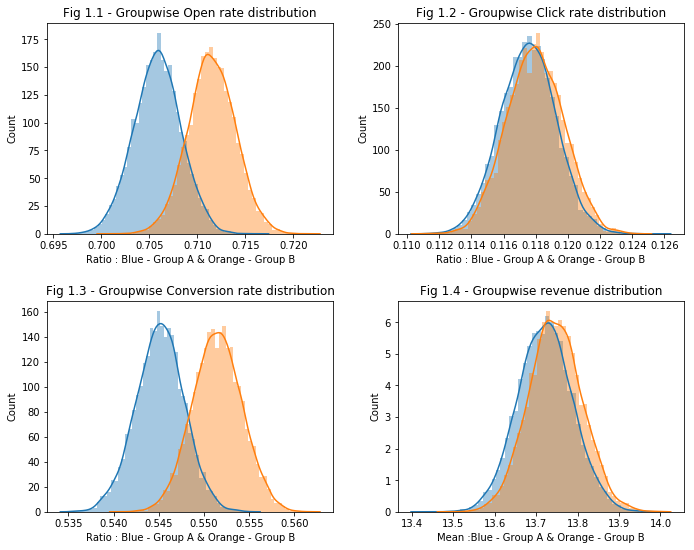

In [30]:
# Visualizing using seaborn package
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

g1 =sns.distplot(open_dist['Group_A'], ax= ax[0,0],norm_hist=True)
g1 =sns.distplot(open_dist['Group_B'], ax= ax[0,0],norm_hist=True)
g1.set_title('Fig 1.1 - Groupwise Open rate distribution')
g1.set(xlabel="Ratio : Blue - Group A & Orange - Group B",ylabel ="Count")

g2 =sns.distplot(click_dist['Group_A'], ax= ax[0,1],label = 'Group A')
g2 =sns.distplot(click_dist['Group_B'], ax= ax[0,1],label = 'Group B')
g2.set_title('Fig 1.2 - Groupwise Click rate distribution')
g2.set(xlabel="Ratio : Blue - Group A & Orange - Group B",ylabel ="Count")

g3 =sns.distplot(conversion_dist['Group_A'], ax= ax[1,0],label = 'Group A')
g3 =sns.distplot(conversion_dist['Group_B'], ax= ax[1,0],label = 'Group B')
g3.set_title('Fig 1.3 - Groupwise Conversion rate distribution')
g3.set(xlabel="Ratio : Blue - Group A & Orange - Group B",ylabel ="Count")

g4 =sns.distplot(revenue_dist['Group_A'], ax= ax[1,1],label = 'Group A')
g4 =sns.distplot(revenue_dist['Group_B'], ax= ax[1,1],label = 'Group B')
g4.set_title('Fig 1.4 - Groupwise revenue distribution')
g4.set(xlabel="Mean :Blue - Group A & Orange - Group B",ylabel ="Count")
fig.tight_layout(pad=2)
plt.show()

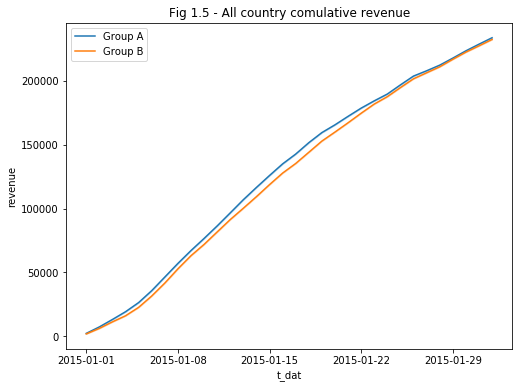

In [68]:
# plot for comulative revenue over the times in the respective groups
obns_a = A_group_df.shape[0]
obns_b = B_group_df.shape[0]

fig, ax = plt.subplots( figsize=(8, 6))
g1 = sns.lineplot(x= A_group_df['t_dat'], y= A_group_df['revenue'].cumsum(),label = "Group A")
g1 = sns.lineplot(x= B_group_df['t_dat'], y= B_group_df['revenue'].cumsum(), label ="Group B")
g1.set_title('Fig 1.5 - All country comulative revenue')
plt.show()

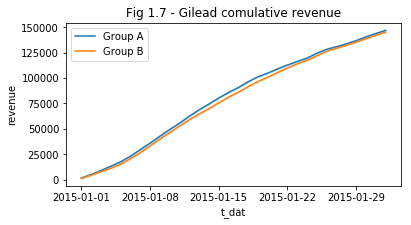

In [77]:
Atlantis_df
Gilead_df  
Oceania_df 

group_A = Gilead_df[Gilead_df['Treatment_Group'] == 'Group A']
group_B = Gilead_df[Gilead_df['Treatment_Group'] == 'Group B']
# plot for comulative revenue over the times in the respective groups
# obns_a = A_group_df.shape[0]
# obns_b = B_group_df.shape[0]

fig, ax = plt.subplots(figsize=(6,3))
g1 = sns.lineplot(x= group_A['t_dat'], y= group_A['revenue'].cumsum(),label = "Group A")
g1 = sns.lineplot(x= group_B['t_dat'], y= group_B['revenue'].cumsum(),label ="Group B")
g1.set_title('Fig 1.7 - Gilead comulative revenue')
plt.show()

<h3> Creating Function for proportion test and independent T test

In [81]:
# Function for proportion test for dictionary of dataframes with list of KPIs  
def p_test(df_dic,kpi_list):
    alpha = 0.05
    result = []
    
    for value in df_dic.values():
        p_values = []
        for kpi in kpi_list:
            group_a = value.loc[value.Treatment_Group == 'Group A',kpi]
            count_a = group_a.count()
            positive_a = group_a.sum()
    
            group_b = value.loc[value.Treatment_Group == 'Group B',kpi]
            count_b = group_b.count() 
            positive_b = group_b.sum()

            nobs_array = np.array([count_b,count_a])
            positive_array = np.array([positive_b,positive_a])

            statistics , p_value = proportions_ztest(count= positive_array, nobs = nobs_array, value= 0, alternative='larger')
            p_values.append(p_value)
        result.append(p_values)
        
    return pd.DataFrame(result, columns= kpi_list, index = list(df_dic.keys())).transpose()

# Function for Independent T test for dictionary of dataframes with list of KPIs 
def t_test(df_dic,kpi_list):
    
    alpha = 0.05
    result = []
    for value in df_dic.values():
        p_values = []
        for kpi in kpi_list:
            group_a = value.loc[(value.Treatment_Group == 'Group A') & (value[kpi].notnull()),kpi]
            group_b = value.loc[(value.Treatment_Group == 'Group B') & (value[kpi].notnull()),kpi]
            stat, both_sided_p = stats.ttest_ind(group_b,group_a,equal_var = False)
    
            if stat >= 0:
                pval = both_sided_p/2.
            else:
                pval = 1 - both_sided_p/2
    
            p_values.append(pval)
        result.append(p_values)
        
    return pd.DataFrame(result, columns= kpi_list, index = list(df_dic.keys())).transpose()

<h3> Hypothesis Testing (Single sided test) </h3>
<br><b>H0 :</b> Proprtion with in each groups are same Pa = Pb
<br><b> Ha:</b> Proportion in B group > A group
<br> Confidence level of 95% is taken . Alpha = 0.05 

<b> Using statsmodel proportion Z test ( two sample proportion)

In [82]:
# creating list of KPIs to test
p_kpi_list = ['open_rate','click_rate','conversion_rate']

# creating dictionary of dataframes to test ( countrywise segmentation)
df_dic = {'all_country':all_df,'Atlantis':Atlantis_df,'Gilead':Gilead_df,'Oceania':Oceania_df}

# Statistically significant values are shown in green color
result_table = p_test(df_dic= df_dic, kpi_list = p_kpi_list)
result_table.style.applymap(lambda x: "color: grey" if x > 0.05 else "color: green")

# Statistically significant values
# open_rate - Gilead
# conversion_rate - all_country

,all_country,Atlantis,Gilead,Oceania
open_rate,0.0536516,0.420343,0.0104516,0.809643
click_rate,0.435835,0.20773,0.0554597,0.906502
conversion_rate,0.0488496,0.0620188,0.102511,0.508041


<b> Testing through Independent T test

In [83]:
# Also verifying results with Z Proportion test
# creating list of KPIs to test
t_kpi_list = ['open_rate','click_rate','conversion_rate','revenue']

# creating dictionary of dataframes to test ( countrywise segmentation)
df_dic = {'all_country':all_df,'Atlantis':Atlantis_df,'Gilead':Gilead_df,'Oceania':Oceania_df}

# Statistically significant values are shown in green color
result_table = t_test(df_dic= df_dic, kpi_list = t_kpi_list)
result_table.style.applymap(lambda x: "color: grey" if x > 0.06 else "color: green")

# Statistically significant values
# open_rate - Gilead
# conversion_rate - all_country

,all_country,Atlantis,Gilead,Oceania
open_rate,0.0536428,0.420348,0.0104471,0.80959
click_rate,0.435837,0.20779,0.0555175,0.906505
conversion_rate,0.0488489,0.0620129,0.102515,0.50804
revenue,0.392107,0.260475,0.5577,0.482348
